# Comparing McQuillan and Starspot Periods

In [1]:
#tools
from tqdm import tqdm
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import astropy.stats as astat
import lightkurve as lk
from solartwins import *
import eleanor
import pickle
import eleanor
from IPython.display import Image
import lightkurve as lk
from starspot import sigma_clipping
import starspot as ss
from lightkurve import search_targetpixelfile
from IPython.display import display, HTML
import starspot.rotation_tools as rt

In [2]:
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=False)

# Opening saved files

In [3]:
#list of stars, target num, sector in tess with two minute cadences
with open('two_result.data', 'rb') as filehandle:
    search_result_two = pickle.load(filehandle)

#stars, target num, sector with thirty minute cadences
with open('thirty_result.data', 'rb') as filehandle:
    search_result_thirty = pickle.load(filehandle)

#names of stars with thirty minute cadences
with open('thirty_m_cadence.data', 'rb') as filehandle:
    thirty_m_cadence = pickle.load(filehandle)
    
#names of stars with two minute cadences
with open('two_m_cadence.data', 'rb') as filehandle:
    two_m_cadence = pickle.load(filehandle)

In [4]:
# opening young stars and ages data from AutoCorrelations

with open('young_stars_dict.data', 'rb') as filehandle:
    young_stars = pickle.load(filehandle) #list of two min cadence target names and sectors
    
with open('young_star_names.data', 'rb') as filehandle:
    young_star_names = pickle.load(filehandle) #list of two min cadence target names and sectors

# McQuillan Autocorrelation Function

In [5]:
# importing data from McQuillan et al 2012
with open('McQuillan_Supplementary_Data/table5.txt', 'r') as f:
    no_rotation_period_txt = f.readlines()
with open('McQuillan_Supplementary_Data/table2.txt', 'r') as f:
    m_dwarf_rotation_period_txt = f.readlines()
with open('McQuillan_Supplementary_Data/table3.txt', 'r') as f:
    giants_txt = f.readlines()
with open('McQuillan_Supplementary_Data/table4.txt', 'r') as f:
    two_periods_txt = f.readlines()

In [6]:
#converting txt files to DataFrames 
m_dwarf_rotation_period = pd.DataFrame([sub.split(",") for sub in m_dwarf_rotation_period_txt])
giants = pd.DataFrame([sub.split(",") for sub in giants_txt])
two_periods = pd.DataFrame([sub.split(",") for sub in two_periods_txt])
no_rotation_period = pd.DataFrame([sub.split(",") for sub in no_rotation_period_txt])

In [7]:
def ac_mcquillan_str_in(star, num_points, k = None): 

    mq_KID = 'KIC ' + star
    tpf_lc = search_targetpixelfile(mq_KID).download_all(quality_bitmask='default');
    
    if len(tpf_lc) > 1:
        lc_mq = tpf_lc[1].to_lightcurve(aperture_mask=tpf_lc[1].pipeline_mask).remove_outliers(sigma=5).bin(binsize=10);
    if len(tpf_lc) > 2: 
        lc_mq = tpf_lc[2].to_lightcurve(aperture_mask=tpf_lc[2].pipeline_mask).remove_outliers(sigma=5).bin(binsize=10);
    else: 
        lc_mq = tpf_lc.to_lightcurve(aperture_mask=tpf_lc.pipeline_mask).remove_outliers(sigma=5).bin(binsize=10);

    
    varied_k = [] #array of autocorrelated fluxes for a given star with varied lag time 
    flux = lc_mq.flux[0:] 
    N = len(flux)
    time = lc_mq.time[0:]
    dt = time[1] - time[0] #cadence
    
    if k is None: 
        k = np.linspace(5, (N/2), num_points, dtype = int) #lag time
    
    flux_bar = np.average(flux)
    
    #equation for McQuillan's AC function
    for i, v in enumerate(k): 
        numerator = []
        for ii in range(N - k[i]): 
            num = (flux[ii]-flux_bar)*(flux[ii + k[i]] - flux_bar)  
            numerator.append(num)
            
        denominator = []
        for jj in range(N):
            den = (flux[jj]-flux_bar)**2
            denominator.append(den)
            
        rk = (np.sum(numerator)/np.sum(denominator))
        varied_k.append(rk)
    
    tau = k * dt

    return varied_k, tau 

# Plotting Differences in Periods

In [8]:
m_dwarf_rotation_period

,0,1,2,3,4,5,6,7
0,KID,Teff,logg,Mass,Period,Period_Err,Amplitude,Flag\n
1,1162635,3899,4.62,0.5037,15.509,0.064,10.7,NF\n
2,1430893,3956,4.41,0.5260,17.144,0.046,10.4,NF\n
3,1572802,3990,4.48,0.5394,0.368,0.000,74.8,PB\n
4,1721911,3833,4.58,0.4781,28.403,0.394,3.9,NF\n
...,...,...,...,...,...,...,...,...
1566,12646841,3511,4.04,0.3583,3.300,0.030,9.79,NF\n
1567,12688834,3827,4.60,0.4758,19.289,0.087,7.7,NF\n
1568,12689979,3875,4.66,0.4943,29.772,0.516,6.2,NF\n
1569,12691684,3662,4.23,0.4132,38.824,10.378,11.2,NF\n


In [9]:
short_mq_periods = [] # list of periods less than 20 days
short_mq_KID = [] #list of KIDs of stars with periods less than 20 days

for indx, period in enumerate(m_dwarf_rotation_period[4]):
    if period <= '20.0':
        short_mq_periods.append(period)
        short_mq_KID.append(m_dwarf_rotation_period[0][indx])

In [10]:
Kep_ID = np.array(short_mq_KID[1:24])
periods = np.array(short_mq_periods[1:24])
mq_ac = periods.astype(np.float)

my_ac = []
ss_ac_array = []

In [11]:
Kep_ID = np.delete(Kep_ID, 0) #removing faulty value
Kep_ID = np.delete(Kep_ID, 17) #removing faulty value
Kep_ID = np.delete(Kep_ID, 19) 

mq_ac = np.delete(mq_ac, 0)
mq_ac = np.delete(mq_ac, 17)
mq_ac = np.delete(mq_ac, 19)

#function for obtaining starspot periods
def ss_ac(Kepler_ID):
    tess_cadence = 1./24./30.
    ss_ac_tpf = search_targetpixelfile('KIC ' + Kepler_ID).download_all(quality_bitmask='default');
    if len(ss_ac_tpf) > 1:
        lc_ss_ac = ss_ac_tpf[1].to_lightcurve(aperture_mask=ss_ac_tpf[1].pipeline_mask).remove_outliers(sigma=5).bin(binsize=10);
    if len(ss_ac_tpf) > 2: 
        lc_ss_ac = ss_ac_tpf[2].to_lightcurve(aperture_mask=ss_ac_tpf[2].pipeline_mask).remove_outliers(sigma=5).bin(binsize=10);
    else: 
        lc_ss_ac = ss_ac_tpf.to_lightcurve(aperture_mask=ss_ac_tpf.pipeline_mask).remove_outliers(sigma=5).bin(binsize=10);

    med_ss_ac = np.median(lc_ss_ac.flux)
    time_ss_ac = lc_ss_ac.time[0:]
    flux_ss_ac = lc_ss_ac.flux[0:]/med_ss_ac - 1
    yerr_ss_ac = lc_ss_ac.flux_err[0:]/med_ss_ac

    ss_ac_mask = astat.sigma_clip(flux_ss_ac, sigma=1, masked = True)
    flux_ss_ac = flux_ss_ac[~ss_ac_mask.mask]
    time_ss_ac = time_ss_ac[~ss_ac_mask.mask]
    flux_err_ss_ac = yerr_ss_ac[~ss_ac_mask.mask]

    rotate_ss_ac = ss.RotationModel(time_ss_ac, flux_ss_ac, flux_err_ss_ac)

    return rotate_ss_ac.acf_rotation(tess_cadence)

for ii in tqdm(Kep_ID):
    print (ii)
    ss_ac_array.append(ss_ac(ii))

fig, ax = plt.subplots(figsize=(15,10))
ax.scatter(Kep_ID, mq_ac, label = 'McQuillan Period', c ='purple')
#ax.scatter(Kep_ID, my_ac, label = 'My Period', c = 'forestgreen')
ax.scatter(Kep_ID, ss_ac_array, label = 'Starspot Period', c = 'orange')
ax.set_xlabel('Kepler ID')
ax.set_ylabel('Period (days)')
legend = ax.legend(loc='upper left', shadow=True, fontsize='x-large')

In [12]:
tess_cadence = 1./24./30.  # This is a TESS 2 minute cadence star.

In [16]:
# comparing McQ vs Starspot results

The McQuillan ACF period is :  0.368


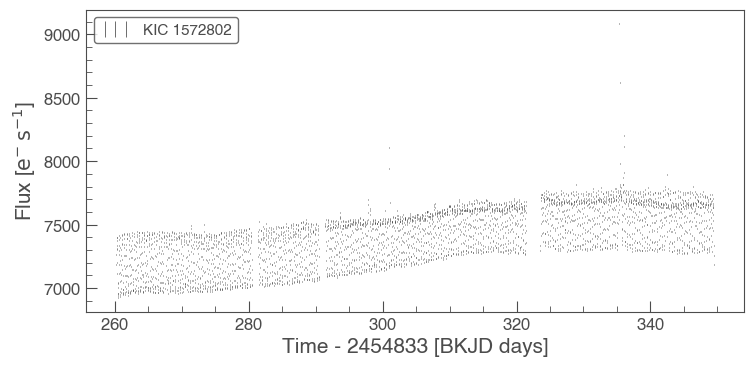

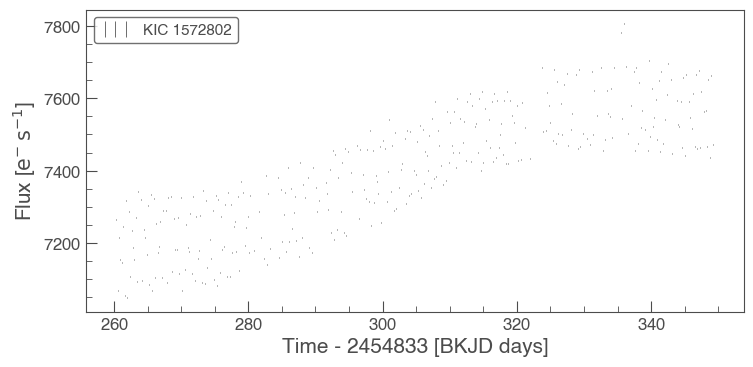

In [30]:
#Young Star #1 from McQuillan dataset
KID_0 = 'KIC ' + Kep_ID[0]
comp_0 = search_targetpixelfile(KID_0).download_all(quality_bitmask='default');
print('The McQuillan ACF period is : ', mq_ac[0])

lc_comp_0 = comp_0[2].to_lightcurve(aperture_mask=comp_0[2].pipeline_mask)
lc_comp_0.errorbar()
lc_comp_0.remove_outliers(sigma=5).bin(binsize=10).errorbar();

In [44]:
ss_comp_0 = search_targetpixelfile(KID_0).download_all(quality_bitmask='default');
lc_0 = ss_comp_0[2].to_lightcurve(aperture_mask=ss_comp_0[2].pipeline_mask).remove_outliers(sigma=6).bin(binsize=10);

med_0 = np.median(lc_0.flux)
time_0 = lc_0.time[0:]
flux_0 = lc_0.flux[0:]/med_0 - 1
yerr_0 = lc_0.flux_err[0:]/med_0

mask_0 = astat.sigma_clip(flux_0, sigma=1, masked = True)
flux_0 = flux_0[~mask_0.mask]
time_0 = time_0[~mask_0.mask]
flux_err_0 = yerr_0[~mask_0.mask]

ConnectionError: HTTPSConnectionPool(host='mast.stsci.edu', port=443): Max retries exceeded with url: /api/v0.1/Download/file?uri=mast:Kepler/url/missions/kepler/target_pixel_files/0015/001572802/kplr001572802-2009259160929_lpd-targ.fits.gz (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x1c46231fd0>: Failed to establish a new connection: [Errno 8] nodename nor servname provided, or not known'))

In [ ]:
rotate_ss_0 = ss.RotationModel(time_0, flux_0, flux_err_0)

In [ ]:
rotate_ss_0.lc_plot()
ls_period_comp_0 = rotate_ss_0.ls_rotation()
acf_period_comp_0 = rotate_ss_0.acf_rotation(tess_cadence)
print('The Lomb-Scargle period is : ', ls_period_comp_0)
print('The ACF period is : ', acf_period_comp_0)

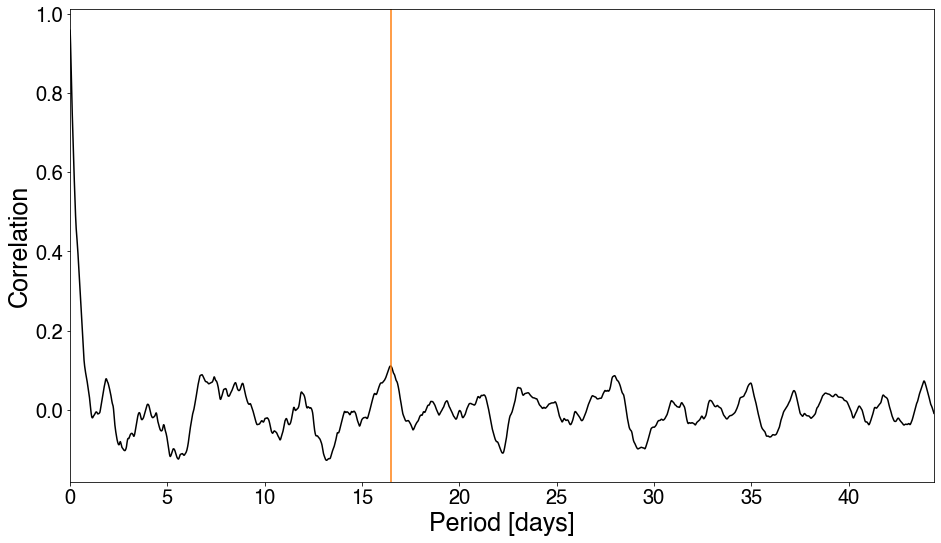

In [21]:
rotate_ss_0.acf_plot();

In [22]:
Kep_ID_0 = ac_mcquillan_str_in(Kep_ID[0], 100);

Text(0.5, 1.0, 'Autocorrelated McQ 0')

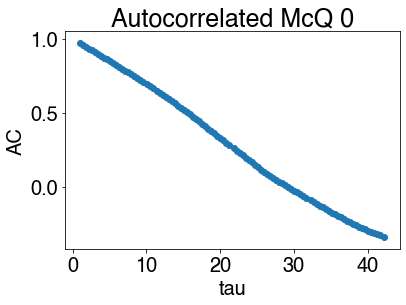

In [23]:
plt.scatter(Kep_ID_0[1], Kep_ID_0[0])
plt.xlabel('tau', fontsize = 20)
plt.ylabel('AC', fontsize = 20)
plt.title('Autocorrelated McQ 0', fontsize = 25)

The McQuillan ACF period is :  11.351


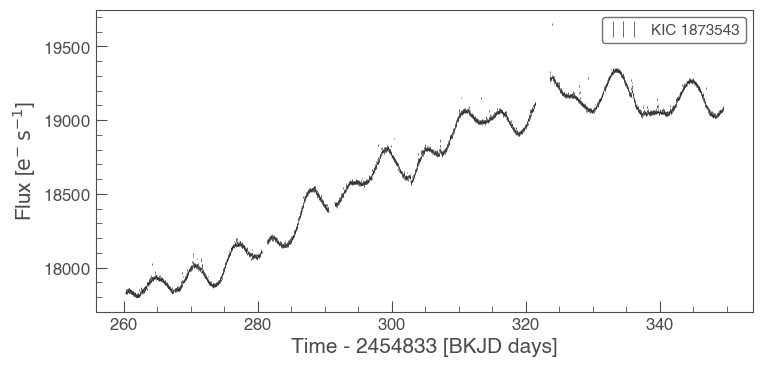

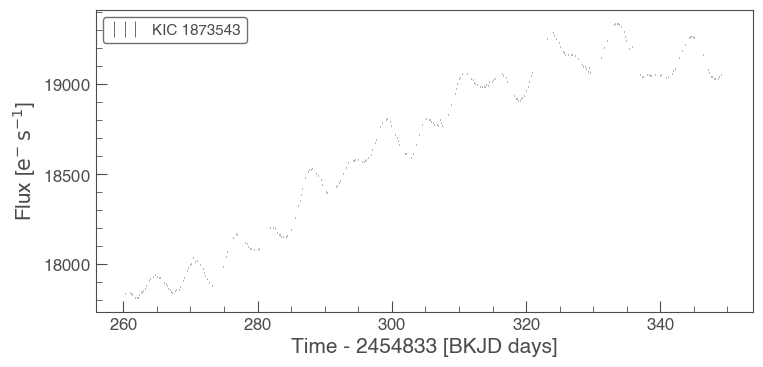

In [33]:
#Young Star #2 from McQuillan dataset

KID_1 = 'KIC ' + Kep_ID[1]
comp_1 = search_targetpixelfile(KID_1).download_all(quality_bitmask='default');
print('The McQuillan ACF period is : ', mq_ac[1])

lc_comp_1 = comp_1[2].to_lightcurve(aperture_mask=comp_1[2].pipeline_mask)
lc_comp_1.errorbar()
lc_comp_1.remove_outliers(sigma=5).bin(binsize=10).errorbar();

In [34]:
ss_comp_1 = search_targetpixelfile(KID_1).download_all(quality_bitmask='default');
lc_1 = ss_comp_1[2].to_lightcurve(aperture_mask=ss_comp_1[2].pipeline_mask).remove_outliers(sigma=6).bin(binsize=10);

med_1 = np.median(lc_1.flux)
time_1 = lc_1.time[0:]
flux_1 = lc_1.flux[0:]/med_1 - 1
yerr_1 = lc_1.flux_err[0:]/med_1

mask_1 = astat.sigma_clip(flux_1, sigma=1, masked = True)
flux_1 = flux_1[~mask_1.mask]
time_1 = time_1[~mask_1.mask]
flux_err_1 = yerr_1[~mask_1.mask]

In [35]:
rotate_ss_1 = ss.RotationModel(time_1, flux_1, flux_err_1)

The Lomb-Scargle period is :  2.5742551318289237
The ACF period is :  4.955555555555555


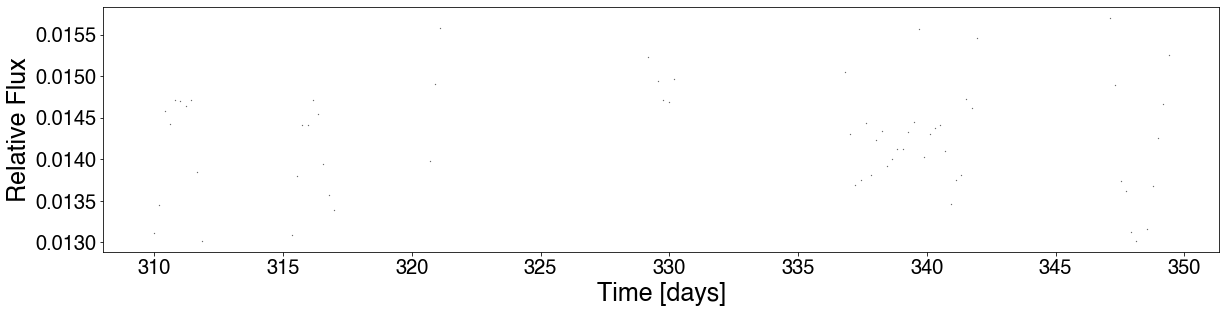

In [36]:
rotate_ss_1.lc_plot()
ls_period_comp_1 = rotate_ss_1.ls_rotation()
acf_period_comp_1 = rotate_ss_1.acf_rotation(tess_cadence)
print('The Lomb-Scargle period is : ', ls_period_comp_1)
print('The ACF period is : ', acf_period_comp_1)

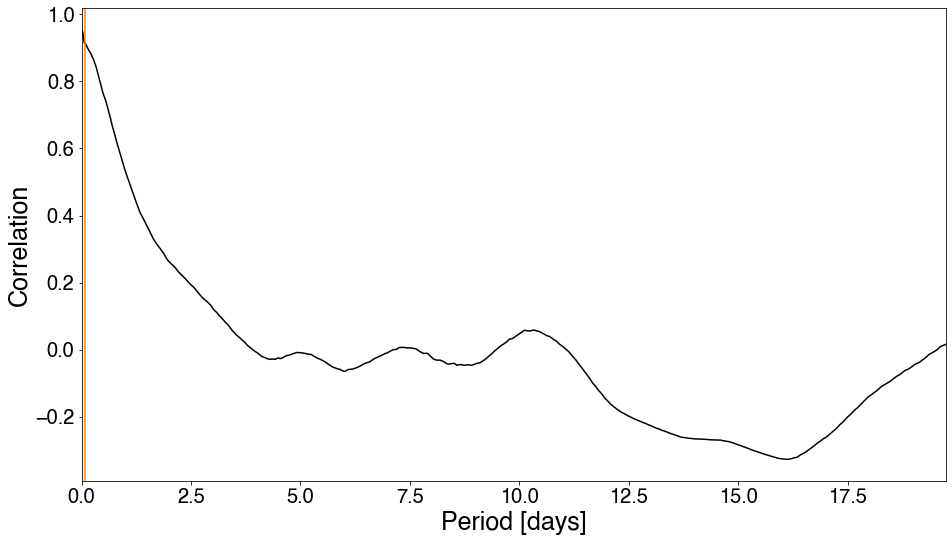

In [28]:
rotate_ss_1.acf_plot();

In [29]:
Kep_ID_1 = ac_mcquillan_str_in(Kep_ID[1], 100);

Text(0.5, 1.0, 'Autocorrelated McQ 1')

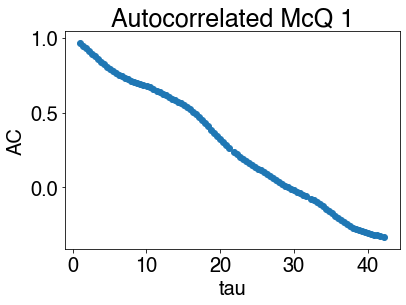

In [30]:
plt.scatter(Kep_ID_1[1], Kep_ID_1[0])
plt.xlabel('tau', fontsize = 20)
plt.ylabel('AC', fontsize = 20)
plt.title('Autocorrelated McQ 1', fontsize = 25)

The McQuillan ACF period is : 18.646


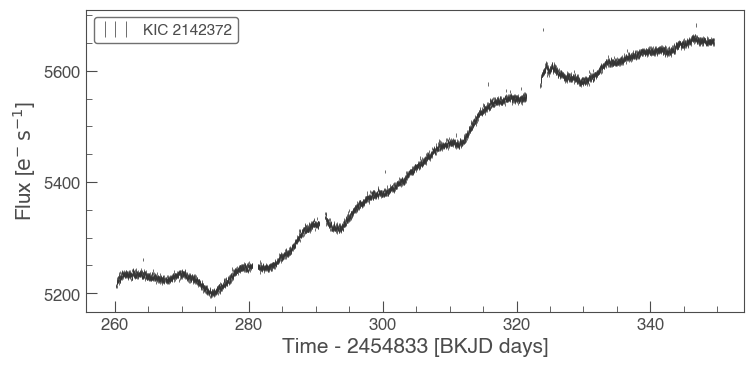

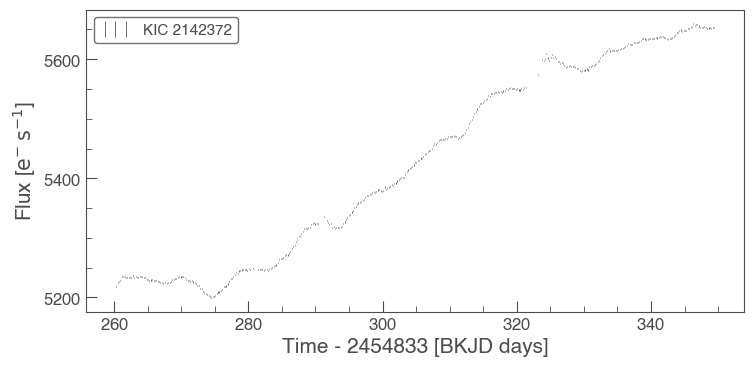

In [31]:
#Young Star #3 from McQuillan dataset

KID_2 = 'KIC ' + Kep_ID[2]
comp_2 = search_targetpixelfile(KID_2).download_all(quality_bitmask='default');
print('The McQuillan ACF period is :', mq_ac[2])

lc_comp_2 = comp_2[2].to_lightcurve(aperture_mask=comp_2[2].pipeline_mask)
lc_comp_2.errorbar()
lc_comp_2.remove_outliers(sigma=5).bin(binsize=10).errorbar();

In [32]:
ss_comp_2 = search_targetpixelfile(KID_2).download_all(quality_bitmask='default');
lc_2 = ss_comp_2[2].to_lightcurve(aperture_mask=ss_comp_2[2].pipeline_mask).remove_outliers(sigma=6)#.bin(binsize=10);

med_2 = np.median(lc_2.flux)
time_2 = lc_2.time[0:]
flux_2 = lc_2.flux[0:]/med_2 - 1
yerr_2 = lc_2.flux_err[0:]/med_2

mask_2 = astat.sigma_clip(flux_2, sigma=1, masked = True)
flux_2 = flux_2[~mask_2.mask]
time_2 = time_2[~mask_2.mask]
flux_err_2 = yerr_2[~mask_2.mask]

In [33]:
rotate_ss_2 = ss.RotationModel(time_2, flux_2, flux_err_2)

The Lomb-Scargle period is :  15.75268664757422
The ACF period is :  0.08333333333333333


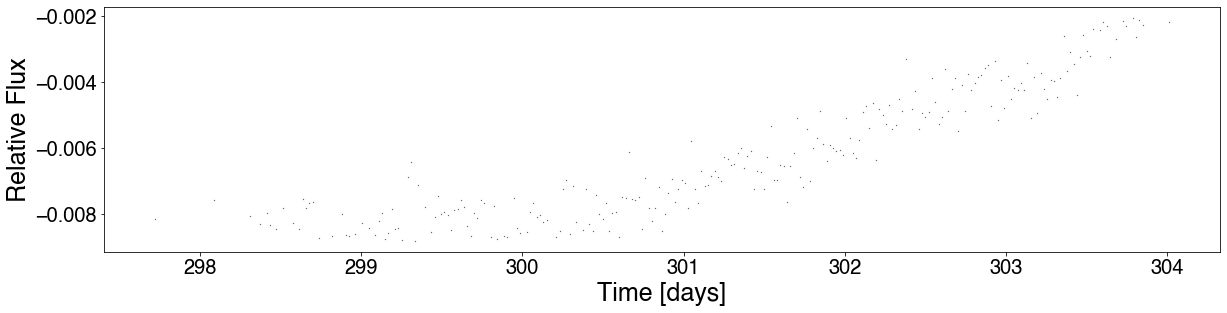

In [34]:
rotate_ss_2.lc_plot()
ls_period_comp_2 = rotate_ss_2.ls_rotation()
acf_period_comp_2 = rotate_ss_2.acf_rotation(tess_cadence)
print('The Lomb-Scargle period is : ', ls_period_comp_2)
print('The ACF period is : ', acf_period_comp_2)

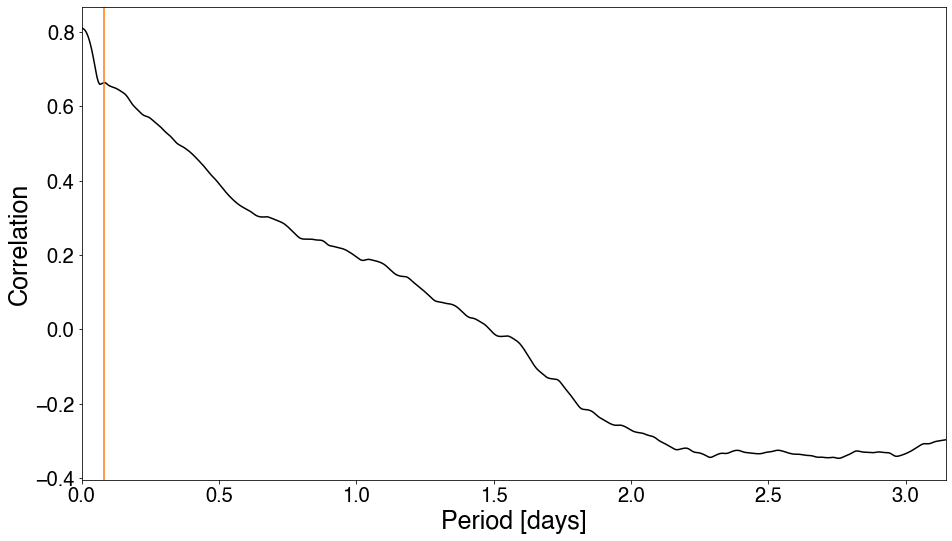

In [35]:
rotate_ss_2.acf_plot();

In [36]:
Kep_ID_2 = ac_mcquillan_str_in(Kep_ID[2], 100);

Text(0.5, 1.0, 'Autocorrelated McQ 2')

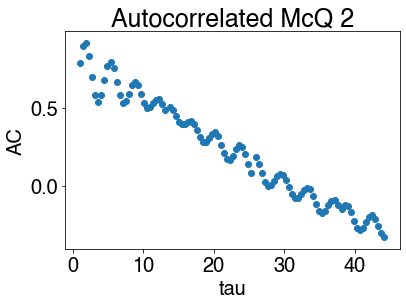

In [37]:
plt.scatter(Kep_ID_2[1], Kep_ID_2[0])
plt.xlabel('tau', fontsize = 20)
plt.ylabel('AC', fontsize = 20)
plt.title('Autocorrelated McQ 2', fontsize = 25)

The McQuillan ACF is :  12.924


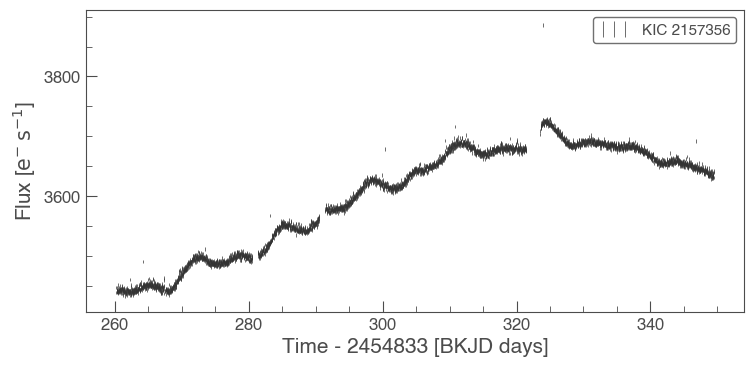

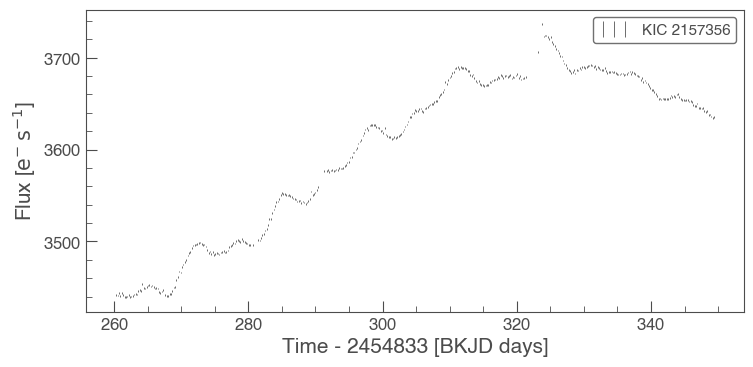

In [38]:
#Young Star #4 from McQuillan dataset

KID_3 = 'KIC ' + Kep_ID[3]
comp_3 = search_targetpixelfile(KID_3).download_all(quality_bitmask='default');
print('The McQuillan ACF is : ', mq_ac[3])

lc_comp_3 = comp_3[2].to_lightcurve(aperture_mask=comp_3[2].pipeline_mask)
lc_comp_3.errorbar()
lc_comp_3.remove_outliers(sigma=5).bin(binsize=10).errorbar();

In [39]:
ss_comp_3 = search_targetpixelfile(KID_3).download_all(quality_bitmask='default');
lc_3 = ss_comp_3[2].to_lightcurve(aperture_mask=ss_comp_3[2].pipeline_mask).remove_outliers(sigma=6).bin(binsize=10);

med_3 = np.median(lc_3.flux)
time_3 = lc_3.time[0:]
flux_3 = lc_3.flux[0:]/med_3 - 1
yerr_3 = lc_3.flux_err[0:]/med_3

mask_3 = astat.sigma_clip(flux_3, sigma=1, masked = True)
flux_3 = flux_3[~mask_3.mask]
time_3 = time_3[~mask_3.mask]
flux_err_3 = yerr_3[~mask_3.mask]

In [40]:
rotate_ss_3 = ss.RotationModel(time_3, flux_3, flux_err_3)

The Lomb-Scargle period is :  24.92708753982142
The ACF period is :  10.941666666666665


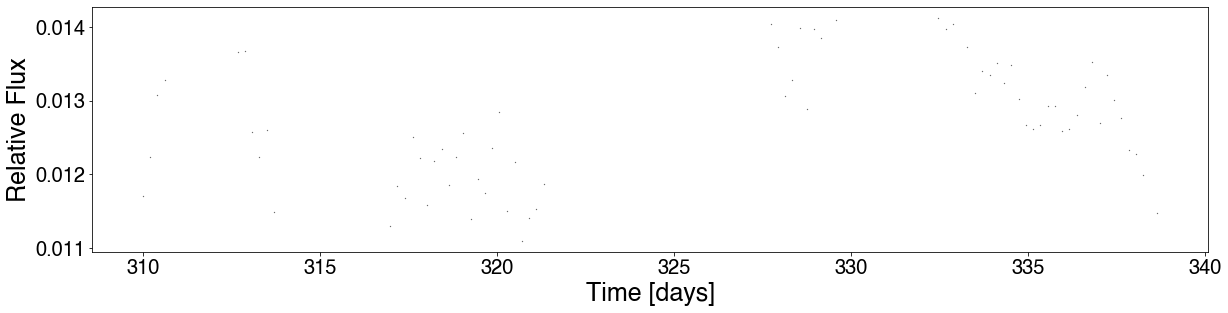

In [41]:
rotate_ss_3.lc_plot()
ls_period_comp_3 = rotate_ss_3.ls_rotation()
acf_period_comp_3 = rotate_ss_3.acf_rotation(tess_cadence)
print('The Lomb-Scargle period is : ', ls_period_comp_3)
print('The ACF period is : ', acf_period_comp_3)

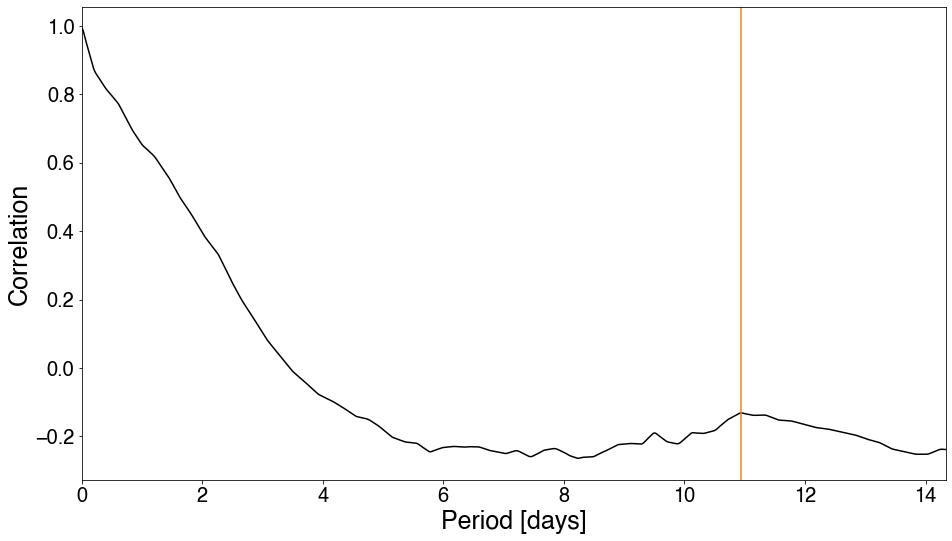

In [42]:
rotate_ss_3.acf_plot();

In [43]:
Kep_ID_3 = ac_mcquillan_str_in(Kep_ID[3], 100);

Text(0.5, 1.0, 'Autocorrelated McQ 3')

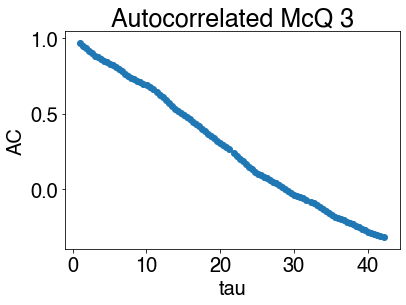

In [44]:
plt.scatter(Kep_ID_3[1], Kep_ID_3[0])
plt.xlabel('tau', fontsize = 20)
plt.ylabel('AC', fontsize = 20)
plt.title('Autocorrelated McQ 3', fontsize = 25)

The McQuillan ACF is :  17.328


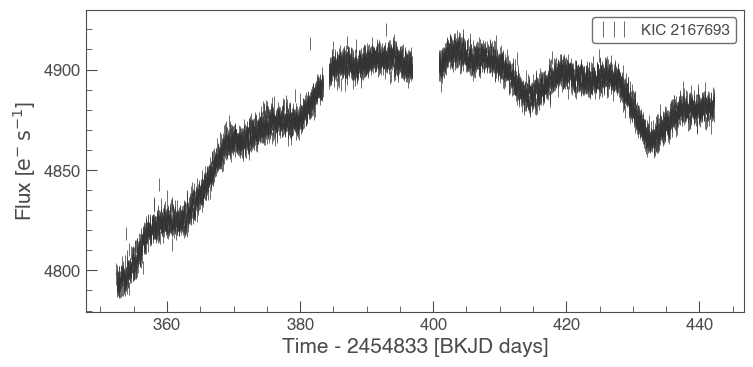

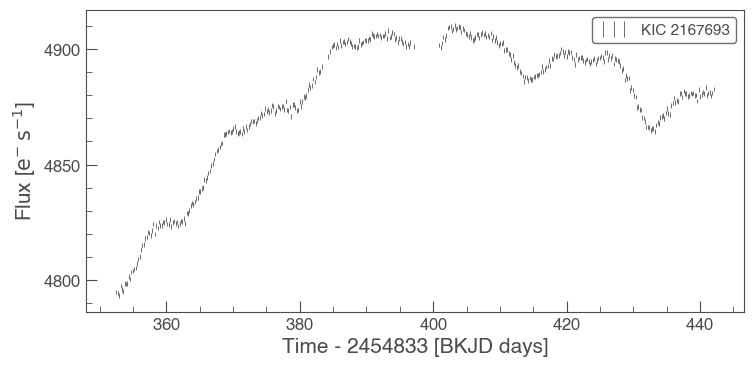

In [37]:
#Young Star #5 from McQuillan dataset

KID_4 = 'KIC ' + Kep_ID[4]
comp_4 = search_targetpixelfile(KID_4).download_all(quality_bitmask='default');
print('The McQuillan ACF is : ', mq_ac[4])

lc_comp_4 = comp_4[3].to_lightcurve(aperture_mask=comp_4[3].pipeline_mask)
lc_comp_4.errorbar()
lc_comp_4.remove_outliers(sigma=5).bin(binsize=10).errorbar();

In [38]:
ss_comp_4 = search_targetpixelfile(KID_4).download_all(quality_bitmask='default');
lc_4 = ss_comp_4[3].to_lightcurve(aperture_mask=ss_comp_4[3].pipeline_mask).remove_outliers(sigma=6).bin(binsize=10);

med_4 = np.median(lc_4.flux)
time_4 = lc_4.time[0:]
flux_4 = lc_4.flux[0:]/med_4 - 1
yerr_4 = lc_4.flux_err[0:]/med_4

mask_4 = astat.sigma_clip(flux_4, sigma=1, masked = True)
flux_4 = flux_4[~mask_4.mask]
time_4 = time_4[~mask_4.mask]
flux_err_4 = yerr_4[~mask_4.mask]

In [39]:
rotate_ss_4 = ss.RotationModel(time_4, flux_4, flux_err_4)

The Lomb-Scargle period is :  23.198179388675463
The ACF period is :  1.0069444444444444


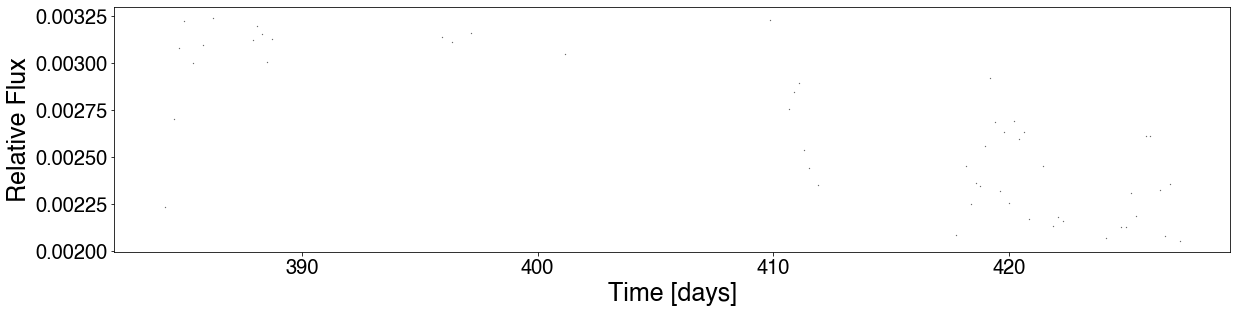

In [40]:
rotate_ss_4.lc_plot()
ls_period_comp_4 = rotate_ss_4.ls_rotation()
acf_period_comp_4 = rotate_ss_4.acf_rotation(tess_cadence)
print('The Lomb-Scargle period is : ', ls_period_comp_4)
print('The ACF period is : ', acf_period_comp_4)

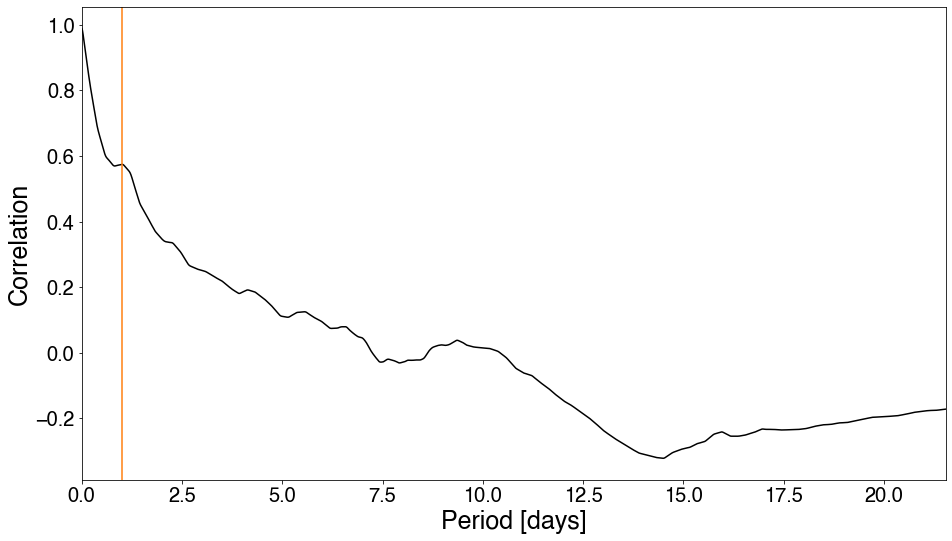

In [41]:
rotate_ss_4.acf_plot();

In [13]:
Kep_ID_4 = ac_mcquillan_str_in(Kep_ID[4], 100);

Text(0.5, 1.0, 'Autocorrelated McQ 4')

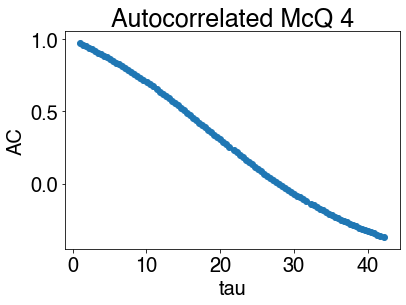

In [14]:
plt.scatter(Kep_ID_4[1], Kep_ID_4[0])
plt.xlabel('tau', fontsize = 20)
plt.ylabel('AC', fontsize = 20)
plt.title('Autocorrelated McQ 4', fontsize = 25)

The McQuillan ACF is :  1.716


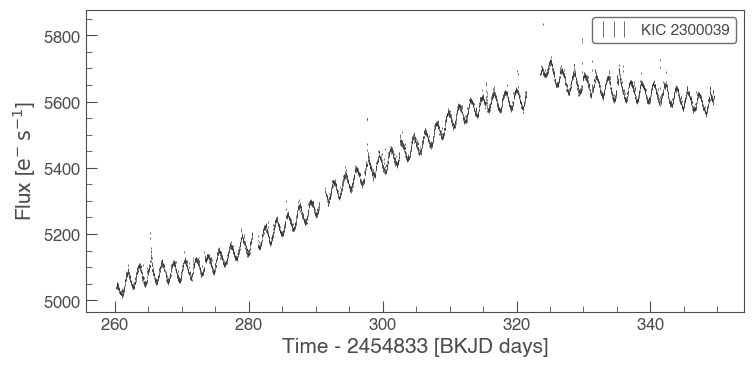

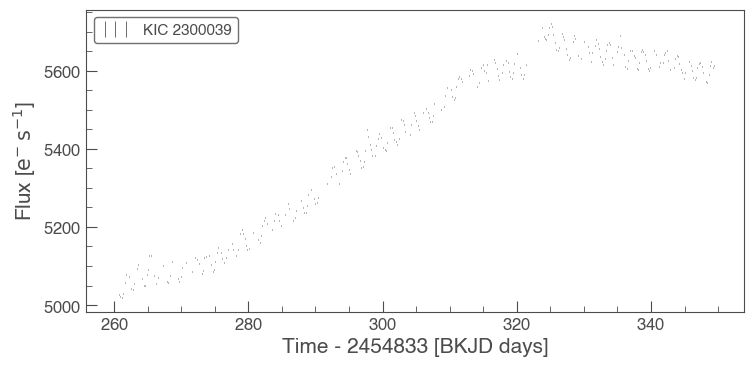

In [15]:
#Young Star #6 from McQuillan dataset

KID_5 = 'KIC ' + Kep_ID[5]
comp_5 = search_targetpixelfile(KID_5).download_all(quality_bitmask='default');
print('The McQuillan ACF is : ', mq_ac[5])

lc_comp_5 = comp_5[2].to_lightcurve(aperture_mask=comp_5[2].pipeline_mask)
lc_comp_5.errorbar()
lc_comp_5.remove_outliers(sigma=5).bin(binsize=10).errorbar();

In [16]:
ss_comp_5 = search_targetpixelfile(KID_5).download_all(quality_bitmask='default');
lc_5 = ss_comp_5[2].to_lightcurve(aperture_mask=ss_comp_5[2].pipeline_mask).remove_outliers(sigma=6).bin(binsize=10);

med_5 = np.median(lc_5.flux)
time_5 = lc_5.time[0:]
flux_5 = lc_5.flux[0:]/med_5 - 1
yerr_5 = lc_5.flux_err[0:]/med_5

mask_5 = astat.sigma_clip(flux_5, sigma=1, masked = True)
flux_5 = flux_5[~mask_5.mask]
time_5 = time_5[~mask_5.mask]
flux_err_5 = yerr_5[~mask_5.mask]

In [17]:
rotate_ss_5 = ss.RotationModel(time_5, flux_5, flux_err_5)

The Lomb-Scargle period is :  0.8057638475930787
The ACF period is :  1.648611111111111


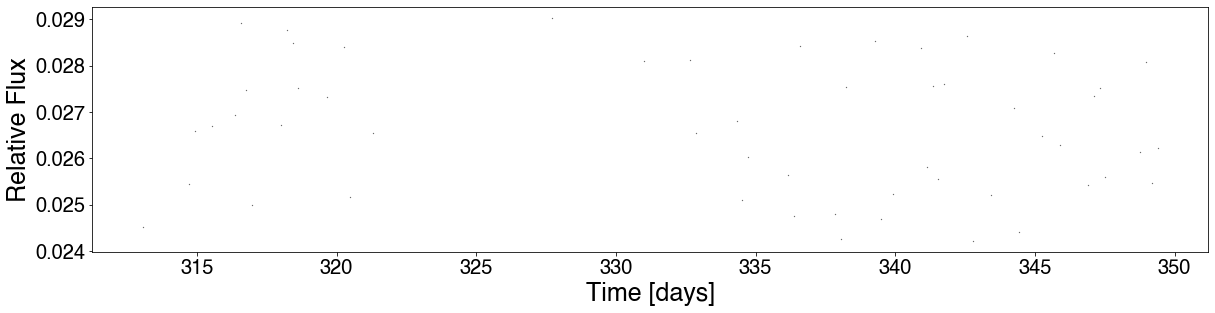

In [18]:
rotate_ss_5.lc_plot()
ls_period_comp_5 = rotate_ss_5.ls_rotation()
acf_period_comp_5 = rotate_ss_5.acf_rotation(tess_cadence)
print('The Lomb-Scargle period is : ', ls_period_comp_5)
print('The ACF period is : ', acf_period_comp_5)

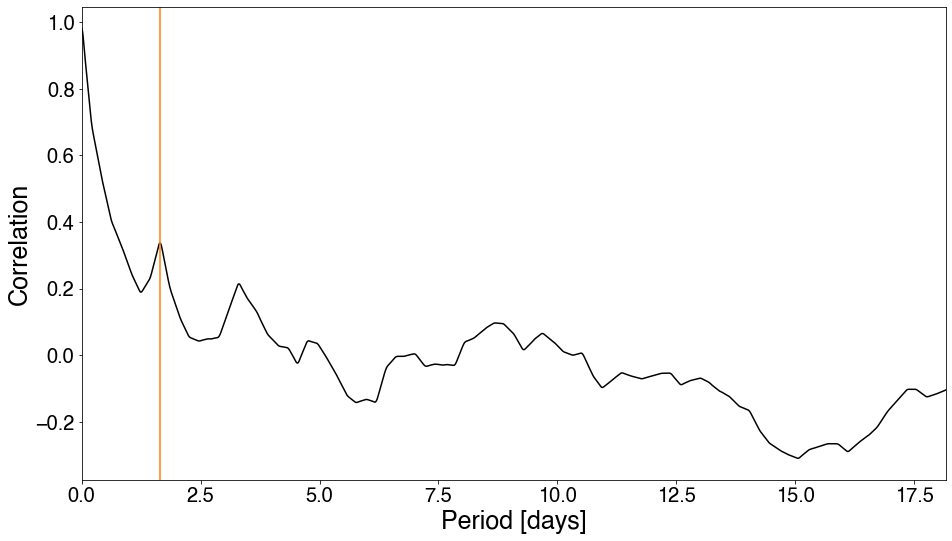

In [19]:
rotate_ss_5.acf_plot();

In [22]:
Kep_ID_5 = ac_mcquillan_str_in(Kep_ID[5], 100);

Text(0.5, 1.0, 'Autocorrelated McQ 5')

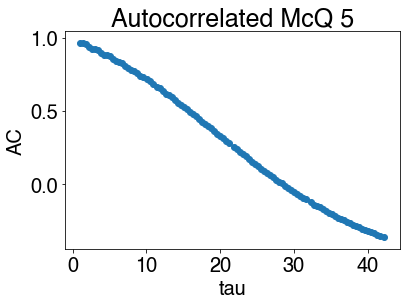

In [33]:
plt.scatter(Kep_ID_5[1], Kep_ID_5[0])
plt.xlabel('tau', fontsize = 20)
plt.ylabel('AC', fontsize = 20)
plt.title('Autocorrelated McQ 5', fontsize = 25)

The McQuillan ACF is :  12.178


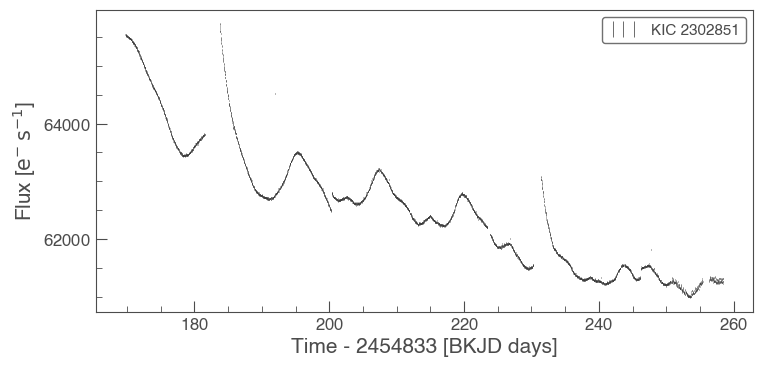

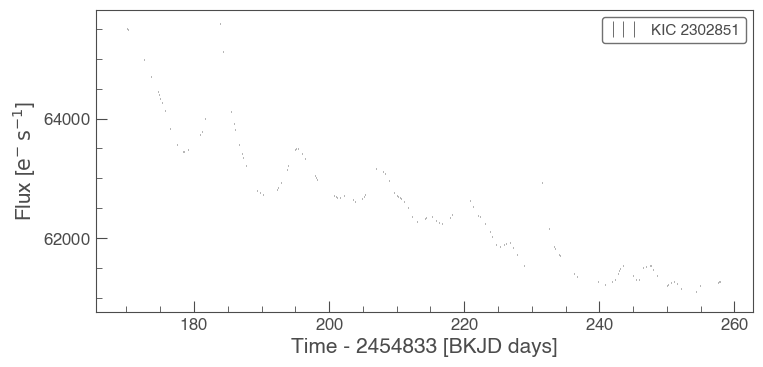

In [25]:
#Young Star #7 from McQuillan dataset

KID_6 = 'KIC ' + Kep_ID[6]
comp_6 = search_targetpixelfile(KID_6).download_all(quality_bitmask='default');
print('The McQuillan ACF is : ', mq_ac[6])

lc_comp_6 = comp_6[2].to_lightcurve(aperture_mask=comp_6[2].pipeline_mask)
lc_comp_6.errorbar()
lc_comp_6.remove_outliers(sigma=5).bin(binsize=10).errorbar();

In [26]:
ss_comp_6 = search_targetpixelfile(KID_6).download_all(quality_bitmask='default');
lc_6 = ss_comp_6[2].to_lightcurve(aperture_mask=ss_comp_6[2].pipeline_mask).remove_outliers(sigma=6).bin(binsize=10);

med_6 = np.median(lc_6.flux)
time_6 = lc_6.time[0:]
flux_6 = lc_6.flux[0:]/med_6 - 1
yerr_6 = lc_6.flux_err[0:]/med_6

mask_6 = astat.sigma_clip(flux_6, sigma=1, masked = True)
flux_6 = flux_6[~mask_6.mask]
time_6 = time_6[~mask_6.mask]
flux_err_6 = yerr_6[~mask_6.mask]

In [27]:
rotate_ss_6 = ss.RotationModel(time_6, flux_6, flux_err_6)

The Lomb-Scargle period is :  1.7474356998392693
The ACF period is :  10.572222222222221


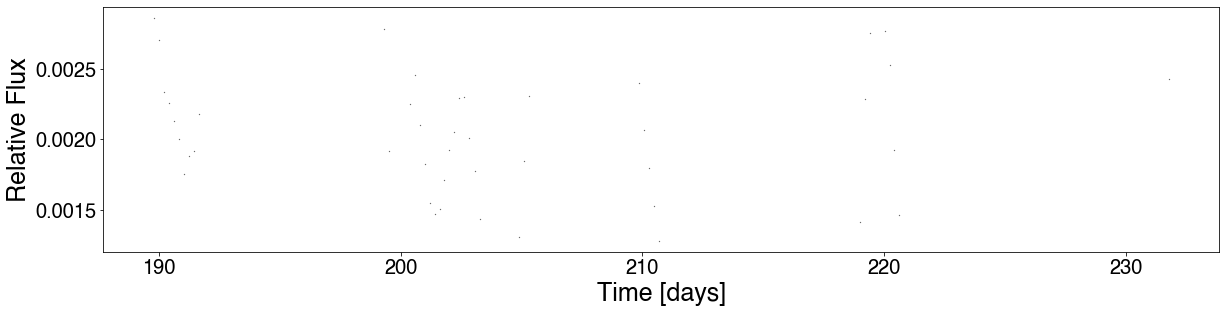

In [28]:
rotate_ss_6.lc_plot()
ls_period_comp_6 = rotate_ss_6.ls_rotation()
acf_period_comp_6 = rotate_ss_6.acf_rotation(tess_cadence)
print('The Lomb-Scargle period is : ', ls_period_comp_6)
print('The ACF period is : ', acf_period_comp_6)

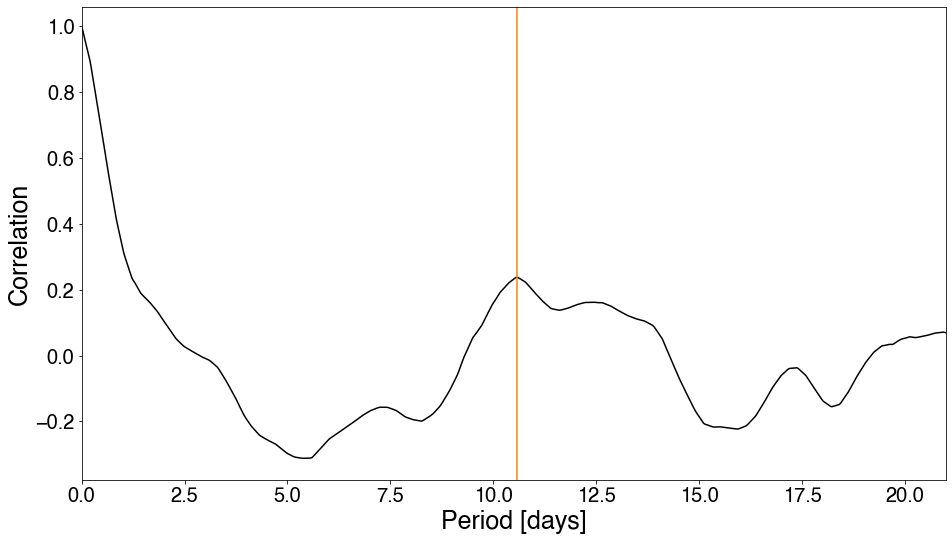

In [29]:
rotate_ss_6.acf_plot();

In [30]:
Kep_ID_6 = ac_mcquillan_str_in(Kep_ID[6], 100);

Text(0.5, 1.0, 'Autocorrelated McQ 6')

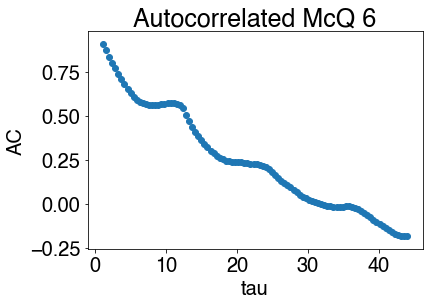

In [32]:
plt.scatter(Kep_ID_6[1], Kep_ID_6[0])
plt.xlabel('tau', fontsize = 20)
plt.ylabel('AC', fontsize = 20)
plt.title('Autocorrelated McQ 6', fontsize = 25)

The McQuillan ACF is :  10.084


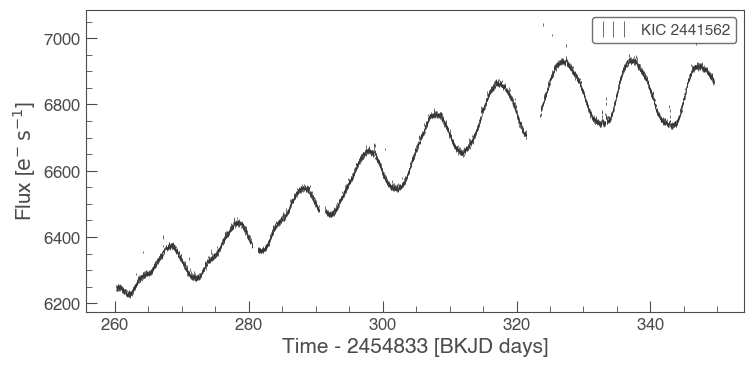

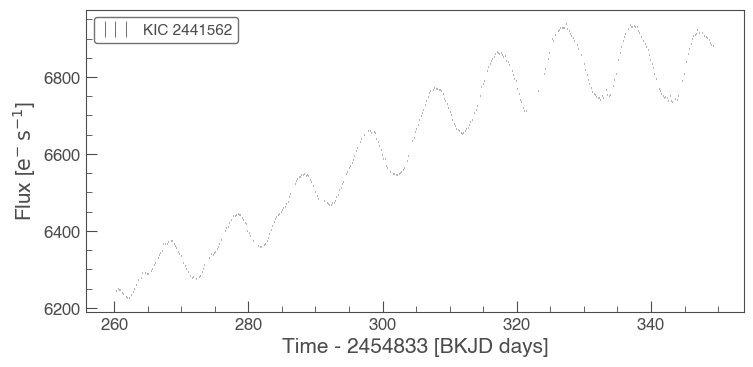

In [34]:
#Young Star #8 from McQuillan dataset

KID_7 = 'KIC ' + Kep_ID[7]
comp_7 = search_targetpixelfile(KID_7).download_all(quality_bitmask='default');
print('The McQuillan ACF is : ', mq_ac[7])

lc_comp_7 = comp_7[2].to_lightcurve(aperture_mask=comp_7[2].pipeline_mask)
lc_comp_7.errorbar()
lc_comp_7.remove_outliers(sigma=5).bin(binsize=10).errorbar();

In [35]:
ss_comp_7 = search_targetpixelfile(KID_7).download_all(quality_bitmask='default');
lc_7 = ss_comp_7[2].to_lightcurve(aperture_mask=ss_comp_7[2].pipeline_mask).remove_outliers(sigma=6).bin(binsize=10);

med_7 = np.median(lc_7.flux)
time_7 = lc_7.time[0:]
flux_7 = lc_7.flux[0:]/med_7 - 1
yerr_7 = lc_7.flux_err[0:]/med_7

mask_7 = astat.sigma_clip(flux_7, sigma=1, masked = True)
flux_7 = flux_7[~mask_7.mask]
time_7 = time_7[~mask_7.mask]
flux_err_7 = yerr_7[~mask_7.mask]

In [36]:
rotate_ss_7 = ss.RotationModel(time_7, flux_7, flux_err_7)

The Lomb-Scargle period is :  5.442833349661997
The ACF period is :  10.515277777777776


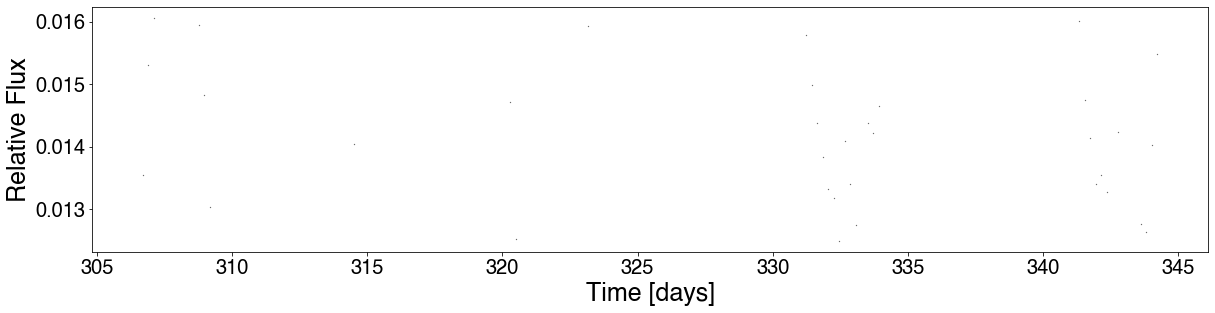

In [37]:
rotate_ss_7.lc_plot()
ls_period_comp_7 = rotate_ss_7.ls_rotation()
acf_period_comp_7 = rotate_ss_7.acf_rotation(tess_cadence)
print('The Lomb-Scargle period is : ', ls_period_comp_7)
print('The ACF period is : ', acf_period_comp_7)

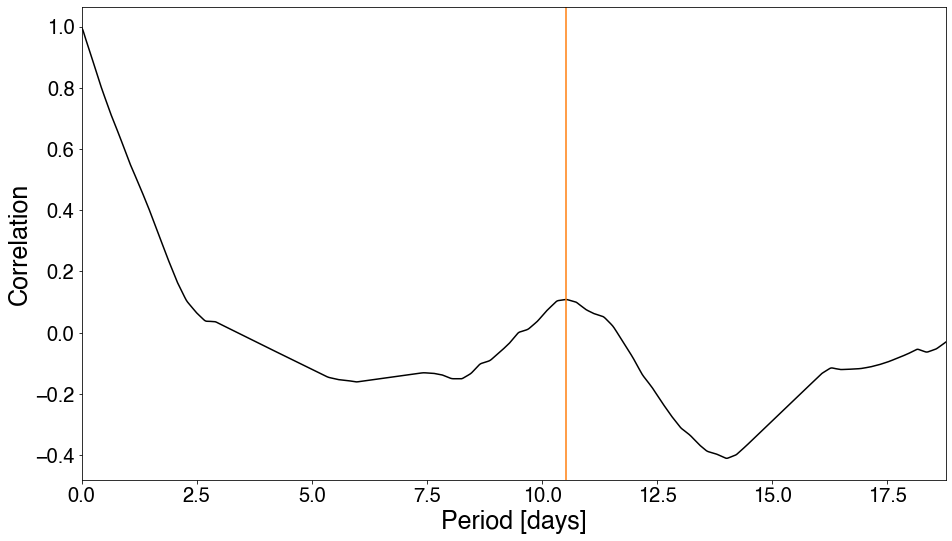

In [38]:
rotate_ss_7.acf_plot();

In [39]:
Kep_ID_7 = ac_mcquillan_str_in(Kep_ID[7], 100);

Text(0.5, 1.0, 'Autocorrelated McQ 7')

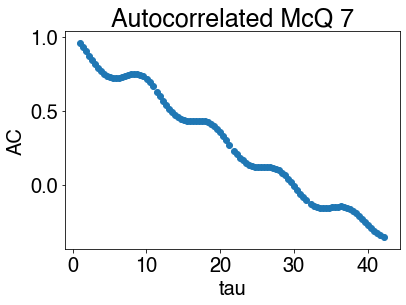

In [40]:
plt.scatter(Kep_ID_7[1], Kep_ID_7[0])
plt.xlabel('tau', fontsize = 20)
plt.ylabel('AC', fontsize = 20)
plt.title('Autocorrelated McQ 7', fontsize = 25)

The McQuillan ACF is :  15.775


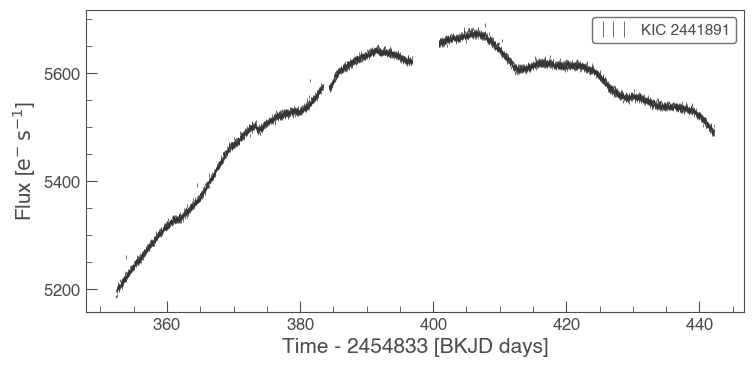

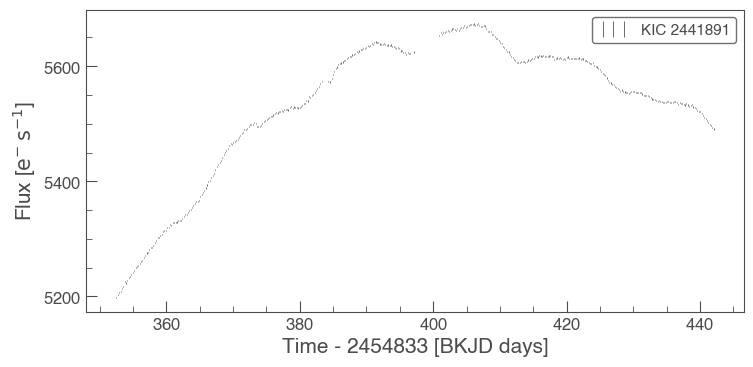

In [42]:
#Young Star #9 from McQuillan dataset

KID_8 = 'KIC ' + Kep_ID[8]
comp_8 = search_targetpixelfile(KID_8).download_all(quality_bitmask='default');
print('The McQuillan ACF is : ', mq_ac[8])

lc_comp_8 = comp_8[3].to_lightcurve(aperture_mask=comp_8[3].pipeline_mask)
lc_comp_8.errorbar()
lc_comp_8.remove_outliers(sigma=5).bin(binsize=10).errorbar();

In [43]:
ss_comp_8 = search_targetpixelfile(KID_8).download_all(quality_bitmask='default');
lc_8 = ss_comp_8[3].to_lightcurve(aperture_mask=ss_comp_8[3].pipeline_mask).remove_outliers(sigma=6).bin(binsize=10);

med_8 = np.median(lc_8.flux)
time_8 = lc_8.time[0:]
flux_8 = lc_8.flux[0:]/med_8 - 1
yerr_8 = lc_8.flux_err[0:]/med_8

mask_8 = astat.sigma_clip(flux_8, sigma=1, masked = True)
flux_8 = flux_8[~mask_8.mask]
time_8 = time_8[~mask_8.mask]
flux_err_8 = yerr_8[~mask_8.mask]

ConnectionError: HTTPSConnectionPool(host='mast.stsci.edu', port=443): Max retries exceeded with url: /api/v0.1/Download/file?uri=mast:Kepler/url/missions/kepler/target_pixel_files/0024/002441891/kplr002441891-2012179063303_lpd-targ.fits.gz (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x1c2cc6bb10>: Failed to establish a new connection: [Errno 8] nodename nor servname provided, or not known'))

In [ ]:
rotate_ss_8 = ss.RotationModel(time_8, flux_8, flux_err_8)

In [ ]:
rotate_ss_8.lc_plot()
ls_period_comp_8 = rotate_ss_8.ls_rotation()
acf_period_comp_8 = rotate_ss_8.acf_rotation(tess_cadence)
print('The Lomb-Scargle period is : ', ls_period_comp_8)
print('The ACF period is : ', acf_period_comp_8)

In [ ]:
rotate_ss_8.acf_plot();

In [46]:
Kep_ID_8 = ac_mcquillan_str_in(Kep_ID[8], 100);

Text(0.5, 1.0, 'Autocorrelated McQ 8')

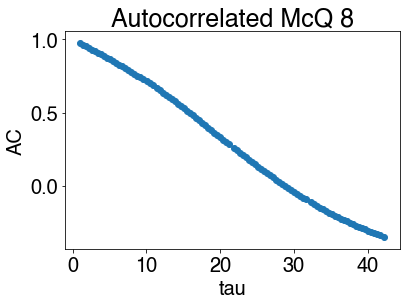

In [47]:
plt.scatter(Kep_ID_8[1], Kep_ID_8[0])
plt.xlabel('tau', fontsize = 20)
plt.ylabel('AC', fontsize = 20)
plt.title('Autocorrelated McQ 8', fontsize = 25)

The McQuillan ACF is :  18.799


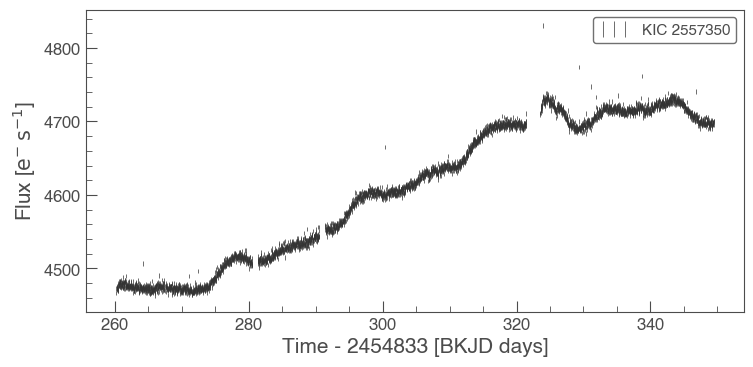

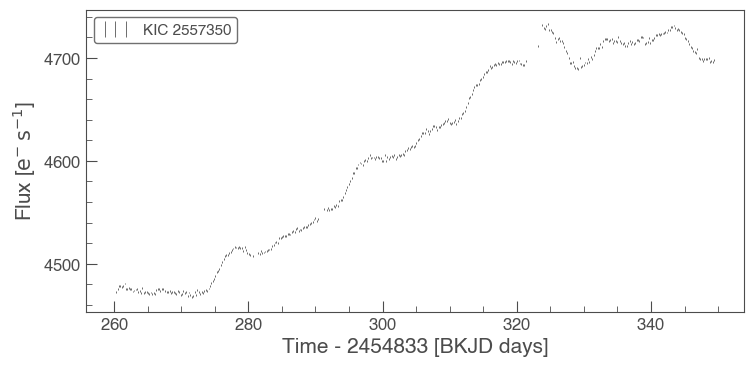

In [48]:
#Young Star #10 from McQuillan dataset

KID_9 = 'KIC ' + Kep_ID[9]
comp_9 = search_targetpixelfile(KID_9).download_all(quality_bitmask='default');
print('The McQuillan ACF is : ', mq_ac[9])

lc_comp_9 = comp_9[2].to_lightcurve(aperture_mask=comp_9[2].pipeline_mask)
lc_comp_9.errorbar()
lc_comp_9.remove_outliers(sigma=5).bin(binsize=10).errorbar();

In [49]:
ss_comp_9 = search_targetpixelfile(KID_9).download_all(quality_bitmask='default');
lc_9 = ss_comp_9[2].to_lightcurve(aperture_mask=ss_comp_9[2].pipeline_mask).remove_outliers(sigma=6).bin(binsize=10);

med_9 = np.median(lc_9.flux)
time_9 = lc_9.time[0:]
flux_9 = lc_9.flux[0:]/med_9 - 1
yerr_9 = lc_9.flux_err[0:]/med_9

mask_9 = astat.sigma_clip(flux_9, sigma=1, masked = True)
flux_9 = flux_9[~mask_9.mask]
time_9 = time_9[~mask_9.mask]
flux_err_9 = yerr_9[~mask_9.mask]

In [50]:
rotate_ss_9 = ss.RotationModel(time_9, flux_9, flux_err_9)

The Lomb-Scargle period is :  4.546644951673228
The ACF period is :  0.2708333333333333


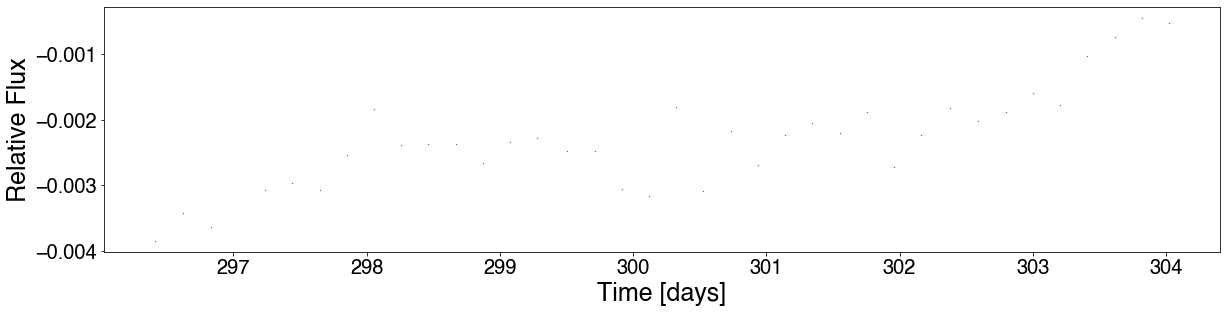

In [51]:
rotate_ss_9.lc_plot()
ls_period_comp_9 = rotate_ss_9.ls_rotation()
acf_period_comp_9 = rotate_ss_9.acf_rotation(tess_cadence)
print('The Lomb-Scargle period is : ', ls_period_comp_9)
print('The ACF period is : ', acf_period_comp_9)

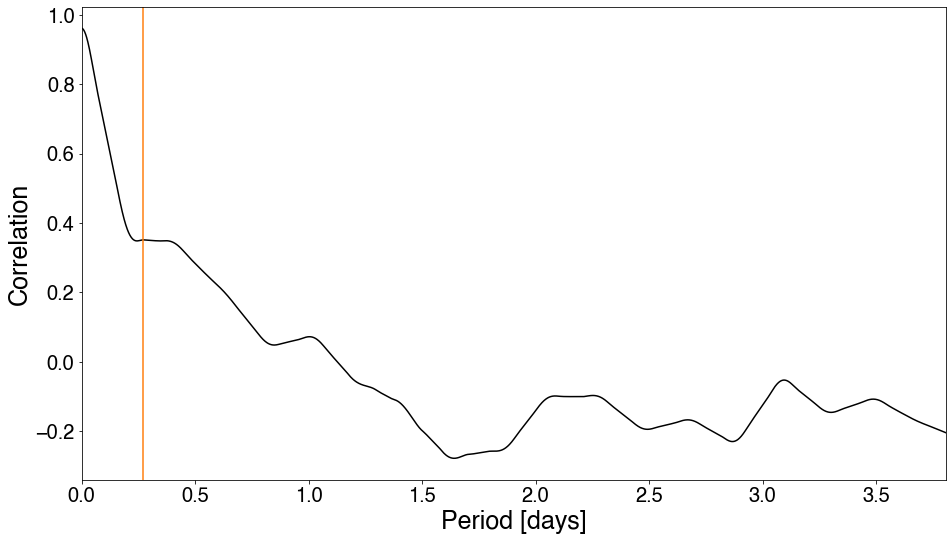

In [52]:
rotate_ss_9.acf_plot();

In [13]:
Kep_ID_9 = ac_mcquillan_str_in(Kep_ID[9], 100);

Text(0.5, 1.0, 'Autocorrelated McQ 9')

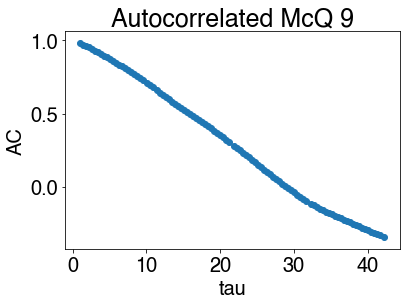

In [14]:
plt.scatter(Kep_ID_9[1], Kep_ID_9[0])
plt.xlabel('tau', fontsize = 20)
plt.ylabel('AC', fontsize = 20)
plt.title('Autocorrelated McQ 9', fontsize = 25)

The McQuillan ACF is :  10.922


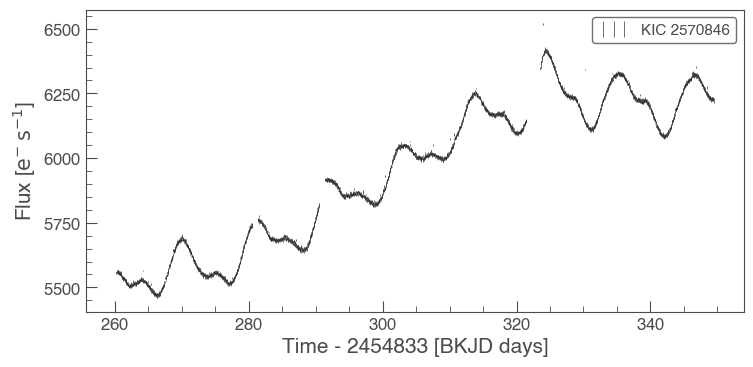

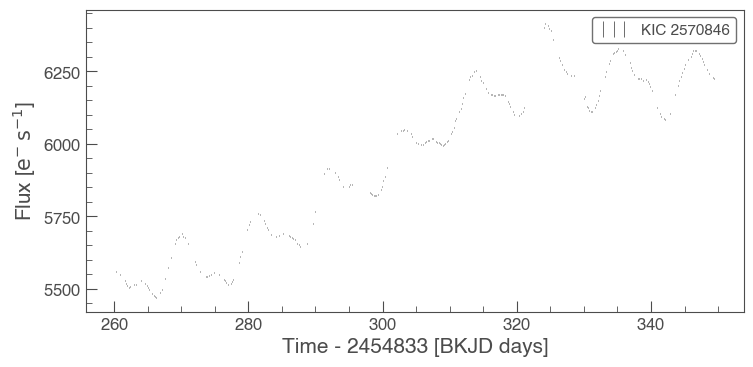

In [15]:
#Young Star #11 from McQuillan dataset

KID_10 = 'KIC ' + Kep_ID[10]
comp_10 = search_targetpixelfile(KID_10).download_all(quality_bitmask='default');
print('The McQuillan ACF is : ', mq_ac[10])

lc_comp_10 = comp_10[2].to_lightcurve(aperture_mask=comp_10[2].pipeline_mask)
lc_comp_10.errorbar()
lc_comp_10.remove_outliers(sigma=5).bin(binsize=10).errorbar();

In [16]:
ss_comp_10 = search_targetpixelfile(KID_10).download_all(quality_bitmask='default');
lc_10 = ss_comp_10[2].to_lightcurve(aperture_mask=ss_comp_10[2].pipeline_mask).remove_outliers(sigma=6).bin(binsize=10);

med_10 = np.median(lc_10.flux)
time_10 = lc_10.time[0:]
flux_10 = lc_10.flux[0:]/med_10 - 1
yerr_10 = lc_10.flux_err[0:]/med_10

mask_10 = astat.sigma_clip(flux_10, sigma=1, masked = True)
flux_10 = flux_10[~mask_10.mask]
time_10 = time_10[~mask_10.mask]
flux_err_10 = yerr_10[~mask_10.mask]

In [17]:
rotate_ss_10 = ss.RotationModel(time_10, flux_10, flux_err_10)

The Lomb-Scargle period is :  0.9522495406302279
The ACF period is :  8.426388888888887


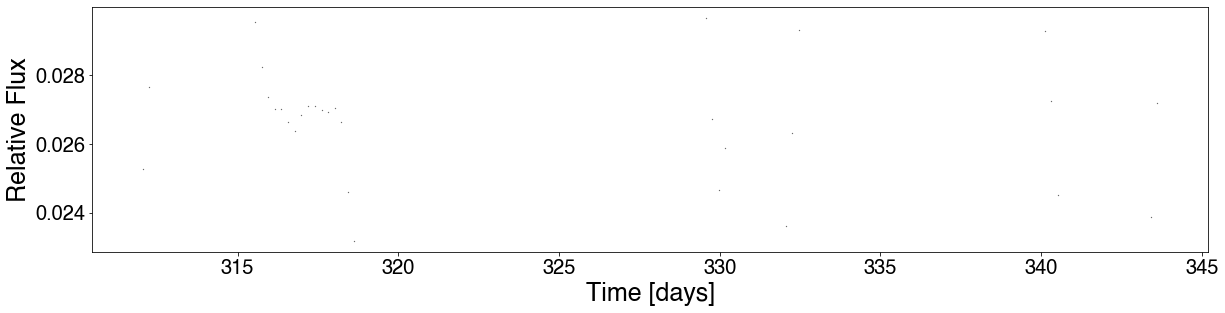

In [18]:
rotate_ss_10.lc_plot()
ls_period_comp_10 = rotate_ss_10.ls_rotation()
acf_period_comp_10 = rotate_ss_10.acf_rotation(tess_cadence)
print('The Lomb-Scargle period is : ', ls_period_comp_10)
print('The ACF period is : ', acf_period_comp_10)

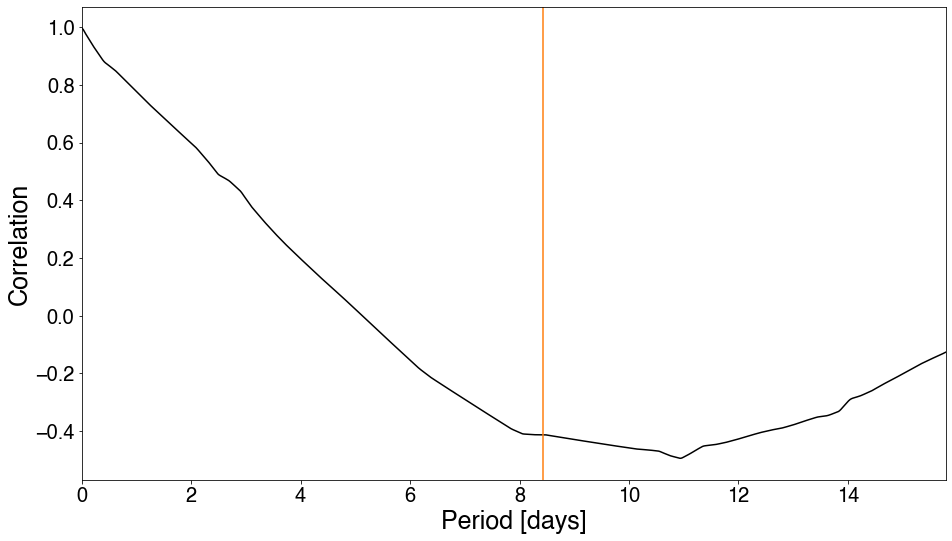

In [19]:
rotate_ss_10.acf_plot();

In [20]:
Kep_ID_10 = ac_mcquillan_str_in(Kep_ID[10], 100);

Text(0.5, 1.0, 'Autocorrelated McQ 10')

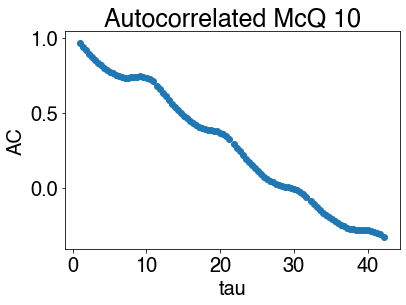

In [21]:
plt.scatter(Kep_ID_10[1], Kep_ID_10[0])
plt.xlabel('tau', fontsize = 20)
plt.ylabel('AC', fontsize = 20)
plt.title('Autocorrelated McQ 10', fontsize = 25)

The McQuillan ACF is :  13.425


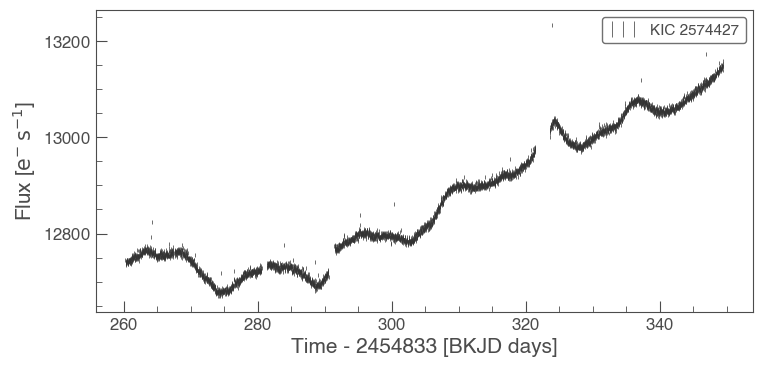

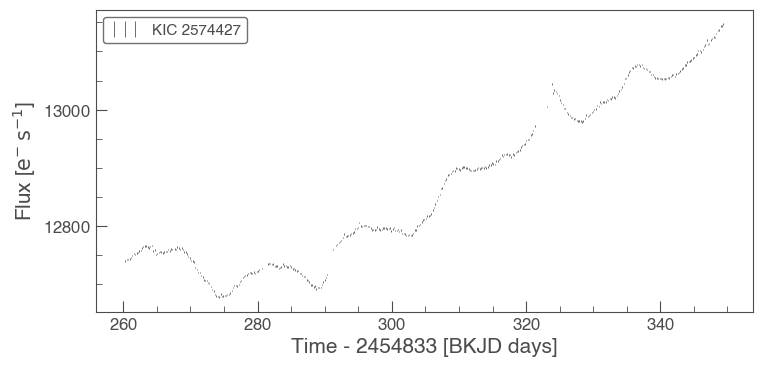

In [22]:
#Young Star #12 from McQuillan dataset

KID_11 = 'KIC ' + Kep_ID[11]
comp_11 = search_targetpixelfile(KID_11).download_all(quality_bitmask='default');
print('The McQuillan ACF is : ', mq_ac[11])

lc_comp_11 = comp_11[2].to_lightcurve(aperture_mask=comp_11[2].pipeline_mask)
lc_comp_11.errorbar()
lc_comp_11.remove_outliers(sigma=5).bin(binsize=10).errorbar();

In [23]:
ss_comp_11 = search_targetpixelfile(KID_11).download_all(quality_bitmask='default');
lc_11 = ss_comp_11[2].to_lightcurve(aperture_mask=ss_comp_11[2].pipeline_mask).remove_outliers(sigma=6).bin(binsize=10);

med_11 = np.median(lc_11.flux)
time_11 = lc_11.time[0:]
flux_11 = lc_11.flux[0:]/med_11 - 1
yerr_11 = lc_11.flux_err[0:]/med_11

mask_11 = astat.sigma_clip(flux_11, sigma=1, masked = True)
flux_11 = flux_11[~mask_11.mask]
time_11 = time_11[~mask_11.mask]
flux_err_11 = yerr_11[~mask_11.mask]

In [24]:
rotate_ss_11 = ss.RotationModel(time_11, flux_11, flux_err_11)

The Lomb-Scargle period is :  4.1056964644673055
The ACF period is :  4.44861111111111


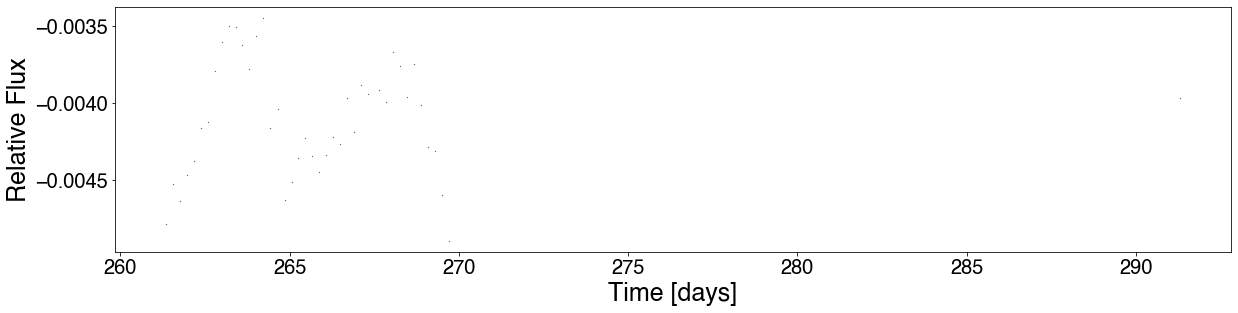

In [25]:
rotate_ss_11.lc_plot()
ls_period_comp_11 = rotate_ss_11.ls_rotation()
acf_period_comp_11 = rotate_ss_11.acf_rotation(tess_cadence)
print('The Lomb-Scargle period is : ', ls_period_comp_11)
print('The ACF period is : ', acf_period_comp_11)

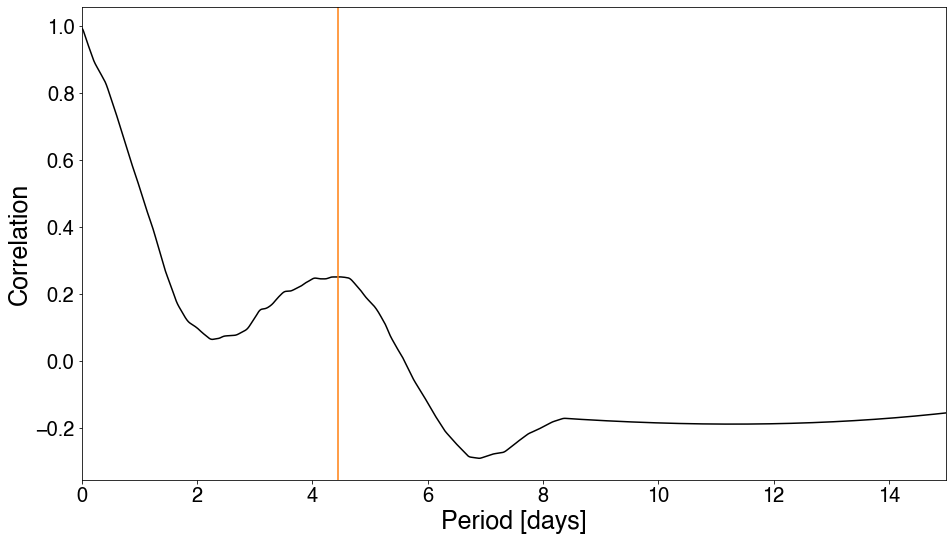

In [26]:
rotate_ss_11.acf_plot();

In [27]:
Kep_ID_11 = ac_mcquillan_str_in(Kep_ID[11], 100);

Text(0.5, 1.0, 'Autocorrelated McQ 11')

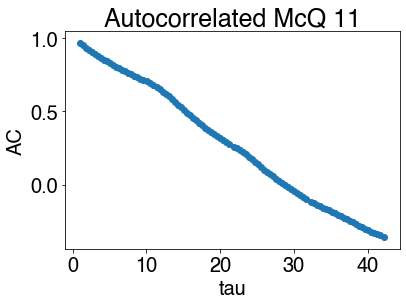

In [28]:
plt.scatter(Kep_ID_11[1], Kep_ID_11[0])
plt.xlabel('tau', fontsize = 20)
plt.ylabel('AC', fontsize = 20)
plt.title('Autocorrelated McQ 11', fontsize = 25)

#Young Star #1 from McQuillan dataset

KID_0 = 'KIC ' + Kep_ID[0]
comp_0 = search_targetpixelfile(KID_0).download_all(quality_bitmask='default');
print('The McQuillan ACF is : ', mq_ac[0])

lc_comp_0 = comp_0[2].to_lightcurve(aperture_mask=comp_0[2].pipeline_mask)
lc_comp_0.errorbar()
lc_comp_0.remove_outliers(sigma=5).bin(binsize=10).errorbar();


ss_comp_0 = search_targetpixelfile(KID_0).download_all(quality_bitmask='default');
lc_0 = ss_comp_0[2].to_lightcurve(aperture_mask=ss_comp_0[2].pipeline_mask).remove_outliers(sigma=6).bin(binsize=10);

med_0 = np.median(lc_0.flux)
time_0 = lc_0.time[0:]
flux_0 = lc_0.flux[0:]/med_0 - 1
yerr_0 = lc_0.flux_err[0:]/med_0

mask_0 = astat.sigma_clip(flux_0, sigma=1, masked = True)
flux_0 = flux_0[~mask_0.mask]
time_0 = time_0[~mask_0.mask]
flux_err_0 = yerr_0[~mask_0.mask]


rotate_ss_0 = ss.RotationModel(time_0, flux_0, flux_err_0)


rotate_ss_0.lc_plot()
ls_period_comp_0 = rotate_ss_0.ls_rotation()
acf_period_comp_0 = rotate_ss_0.acf_rotation(tess_cadence)
print('The Lomb-Scargle period is : ', ls_period_comp_0)
print('The ACF period is : ', acf_period_comp_0)

rotate_ss_0.acf_plot();


Kep_ID_0 = ac_mcquillan_str_in(Kep_ID[0], 100);

plt.scatter(Kep_ID_0[1], Kep_ID_0[0])
plt.xlabel('tau', fontsize = 20)
plt.ylabel('AC', fontsize = 20)
plt.title('Autocorrelated McQ 0', fontsize = 25)